<a href="https://colab.research.google.com/github/Gilf641/EVA4/blob/master/S6_Assignment_Solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Import required Libraries**


In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
%matplotlib inline
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import OneCycleLR

In [0]:
# simple function to upload files from local drive

from google.colab import files
def getLocalFiles():
    _files = files.upload()
    if len(_files) >0:
       for k,v in _files.items():
         open(k,'wb').write(v)
getLocalFiles()

**Data Transformations**


* Here I've created a Class to transform Train & Test Data. And I'm using Compose function to chain in all the transform operations required in the form of list and then pass it on the different sets of data.
* I have already set the mean and the standard deviation to 0.1307 & 0.3081 
* 2 main parameters normalize(boolean) and rotate(default value = 0).


In [0]:
# # Transformations 

# class Transformations():

#   def __init__(self, normalize=True, rotate = 0):
#       self.normalize = normalize
#       self.rotate = rotate


#   # For Train Data
#   def train_transforms(self, tensorToPIL = True):
#       self.tensorToPIL = tensorToPIL
#       transforms_list = []
#       transforms_list.append(transforms.ToTensor())
#       if self.normalize: 
#           transforms_list.append(transforms.Normalize((0.1307, ), (0.3081, )))
#       if self.rotate:
#           transforms_list.append(transforms.RandomRotation((-1*int(self.rotate), int(self.rotate)), fill=(1,)))
#       if self.tensorToPIL:
#           transforms_list.append(transforms.ToPILImage())
#       return transforms.Compose(transforms_list)


#   # For Test Data
#   def test_transforms(self, tensorToPIL = True):
#       self.tensorToPIL = tensorToPIL
#       transforms_list = [transforms.ToTensor()]
#       if self.normalize:
#           transforms_list.append(transforms.Normalize((0.1307, ),(0.3081, )))
#       if self.tensorToPIL:
#           transforms_list.append(transforms.ToPILImage())
#       return transforms.Compose(transforms_list)



# mnist_data = Transformations(normalize = True, rotate = 5)    # set normalize = True
# train_trans = mnist_data.train_transforms(tensorToPIL = True)  # Rotation of Train Images
# test_trans = mnist_data.test_transforms(tensorToPIL = True)

In [0]:
# Transformations

# Train Phase transformations
train_transforms = transforms.Compose([
                                       transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) 
                                      #  transforms.ToPILImage()# The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                      #  transforms.ToPILImage()
                                       ])


In [10]:
# Split Test & Train Data
train = datasets.MNIST('./data', train = True, download = True, transform = train_transforms)
test = datasets.MNIST('./data', train = False, download = True, transform = test_transforms)

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


**Dataloaders Arguments & Train/Test Dataloaders**

In [0]:
# DataLoaders

class Dataloader:
  def __init__(self, shuffle = True, batch_size = 128):
      cuda = torch.cuda.is_available()
      if cuda:
        torch.cuda.manual_seed(seed)
      self.dataloader_args = dict(shuffle=shuffle, batch_size=batch_size, num_workers=4, pin_memory=True) #if cuda else dict(shuffle=True, batch_size=64)

  def dataset_loader(self, data):
      return torch.utils.data.DataLoader(data, **self.dataloader_args) # **dataloader_args get passed when dataset_loader gets called


dl = Dataloader()

# train dataloader
train_loader = dl.dataset_loader(train)

# test dataloader
test_loader = dl.dataset_loader(test)

**Data Statistics**

torch.Size([128, 1, 28, 28])
torch.Size([128])


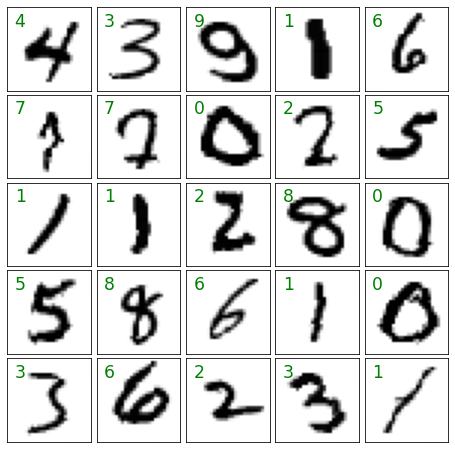

In [12]:

data_iter = iter(train_loader)
images, labels = data_iter.next()

print(images.shape) # [64, 1, 28, 28]
print(labels.shape) # [64]


from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline


def display_25(images, labels):
  figmatrix = plt.figure(figsize=(8, 8))
  row, col = 5, 5 # set rows & columns = 5
  gs = gridspec.GridSpec(row, col)
  gs.update(wspace=0.005, hspace=0.05)

  for i in range(1, 26):
    plt.subplot(gs[i-1])
    plt.tick_params( axis='both', which='both', labelbottom=False, labelleft=False, left=False, bottom=False)
    plt.imshow(images[i-1].numpy().squeeze(), cmap='gray_r')
    plt.text(2, 6, labels[i-1].numpy(), color="green", fontsize="xx-large")
  plt.show()

display_25(images[:25], labels[:25])



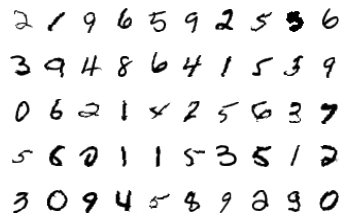

In [0]:
# Just curious at the orientation of these mnist images
figure = plt.figure()
num_of_images = 50
for i in range(1,num_of_images+1):
  plt.subplot(5,10, i)
  plt.axis('off')
  plt.imshow(images[i-1].numpy().squeeze(), cmap = 'gray_r')

In [0]:
# Main Model with Batch Normalization
class Net(nn.Module):
    def __init__(self):
      super(Net, self).__init__()

      # Conv Block1 
      self.convblock1 = nn.Sequential(
          nn.Conv2d(in_channels = 1, out_channels = 8, kernel_size = (3,3), padding = 0, bias = False), 
          nn.ReLU(),
          nn.BatchNorm2d(8)) # O/P: 26
      
      # Conv Block2
      self.convblock2 = nn.Sequential(
          nn.Conv2d(in_channels = 8, out_channels = 10, kernel_size = (3,3), padding = 0, bias = False),
          nn.ReLU(),
          nn.BatchNorm2d(10)) # O/P: 24

      # MaxPool Layer
      self.maxpool = nn.Sequential(nn.MaxPool2d((2,2))) # O/P: 12

      # ConvBlock 3
      self.convblock3 = nn.Sequential(
          nn.Conv2d(in_channels = 10, out_channels = 16, kernel_size = (3,3), padding = 0, bias = False),
          nn.ReLU(),
          nn.BatchNorm2d(16)) # O/P: 10
      
      
      # ConvBlock 4
      self.convblock4 = nn.Sequential(
          nn.Conv2d(in_channels = 16, out_channels = 16, kernel_size = (3,3), padding = 0, bias = False),
          nn.ReLU(),
          nn.BatchNorm2d(16)) # O/P: 8
      
      # ConvBlock 5
      self.convblock5 = nn.Sequential(
          nn.Conv2d(in_channels = 16, out_channels = 16, kernel_size = (3,3), padding = 0, bias = False),
          nn.ReLU(),
          nn.BatchNorm2d(16)) # O/P: 6

      # ConvBlock 6
      self.convblock6 = nn.Sequential(
          nn.Conv2d(in_channels = 16, out_channels = 16, kernel_size = (3,3), padding = 0,  bias = False))
         

    # GAP
      self.gap = nn.Sequential(nn.AvgPool2d(4))

    
    # Last Layer
      self.convblock9 = nn.Sequential(
          nn.Conv2d(in_channels = 16, out_channels = 10, kernel_size = (1,1), padding = 0, bias = False))


    # Dropout Layer
      self.drop = nn.Sequential(nn.Dropout(0.08))



    def forward(self,x):
      x = self.convblock1(x)
      x = self.drop(x)
      x = self.convblock2(x)
      x = self.drop(x)
      x = self.maxpool(x)
      x = self.convblock3(x)
      x = self.drop(x)
      x = self.convblock4(x)
      x = self.drop(x)
      x = self.convblock5(x)
      x = self.convblock6(x)
      x = self.gap(x)
      x = self.convblock9(x)
     
      x = x.view(-1, 10)
      return F.log_softmax(x, dim = -1)
      



In [20]:
# BN Model Summary 
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5           [-1, 10, 24, 24]             720
              ReLU-6           [-1, 10, 24, 24]               0
       BatchNorm2d-7           [-1, 10, 24, 24]              20
           Dropout-8           [-1, 10, 24, 24]               0
         MaxPool2d-9           [-1, 10, 12, 12]               0
           Conv2d-10           [-1, 16, 10, 10]           1,440
             ReLU-11           [-1, 16, 10, 10]               0
      BatchNorm2d-12           [-1, 16, 10, 10]              32
          Dropout-13           [-1, 16, 10, 10]               0
           Conv2d-14             [-1, 1

In [0]:
from tqdm import tqdm
import numpy as np

class Test_Train():
  def __init__(self):

# # This is to hold all the values and plot some graphs to extract few good insights.
    self.train_losses = []
    self.test_losses = []
    self.train_acc = []
    self.test_acc = []
    self.train_epoch_end = []
    self.test_loss_min = np.inf # setting it to infinity(max value)
    # when the test loss becomes min I will save the particular model


  def train(self, model, device, train_loader, optimizer, epoch,scheduler, L1lambda=None):
    model.train()    # prepare model for training
    pbar = tqdm(train_loader)
    correct = 0
    processed = 0
    for batch_idx, (data, target) in enumerate(pbar): # passing on data & target values to device
      data, target = data.to(device), target.to(device)
      optimizer.zero_grad()    # clear the gradients of all optimized variables
      
      # Predict
      y_pred = model(data)   # forward pass

      # Calculate loss
      loss = F.nll_loss(y_pred, target)

      #Implementing L1 Regularization
      if L1lambda:
        with torch.enable_grad():
          l1_loss = 0.
          for param in model.parameters():
            l1_loss += torch.sum(param.abs())
          loss += L1lambda * l1_loss

      self.train_losses.append(loss)

      # Backpropagation
      loss.backward()   # backward pass: compute gradient of the loss with respect to model parameters
      optimizer.step()   # perform a single optimization step (parameter update)

      # Update pbar-tqdm
    
      pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
      correct += pred.eq(target.view_as(pred)).sum().item()
      processed += len(data)

      pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
      self.train_acc.append(100*correct/processed)
      scheduler.step()
      self.train_epoch_end.append(self.train_acc[-1])


  def test(self, model, device, test_loader,filename):
      model.eval()  # prep model for evaluation
      test_loss = 0
      correct = 0
      with torch.no_grad():
          for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)  # forward pass: compute predicted outputs by passing inputs to the model
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

      test_loss /= len(test_loader.dataset)
      self.test_losses.append(test_loss)

      # save model if validation loss has decreased
      if test_loss <= self.test_loss_min:
          print('Validation loss has  decreased ({:.4f} --> {:.4f}).  Saving model ...'.format(self.test_loss_min, test_loss))
          torch.save(model.state_dict(), filename)
          self.test_loss_min = test_loss


      print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
          test_loss, correct, len(test_loader.dataset),
          100. * correct / len(test_loader.dataset)))
    
      self.test_acc.append(100. * correct / len(test_loader.dataset))


  # def plot(graph = None):
  #   super(Test_Train,self).__init__()

  #   if graph == 'Accuracy':
  #     plt.figure(figsize=(15, 10))
  #     ax = plt.subplot(111)
  #     ax.plot(acc1)
  #     ax.plot(acc2)
  #     ax.plot(acc3)
  #     ax.plot(acc4)
  #     ax.set(title="Model Validation Accuracy of 4 Models with Batch-Normalization", xlabel="Epoch", ylabel="Accuracy")
  #     ax.legend(['without L1 and L2', 'with L1', 'with L2', 'with L1 and L2'], loc='best')
  #     plt.savefig("Accuracyof4modelswithBN.png")
  #     plt.show()

    
  #   elif graph == 'Loss':
  #   plt.figure(figsize = (15,10))
  #   ax = plt.subplot(111)
  #   ax.plot(loss1)
  #   ax.plot(loss2)
  #   ax.plot(loss3)
  #   ax.plot(loss4)
  #   ax.set(title='Validation Losses of 4 Models', xlabel='Epoch', ylabel = 'Loss')
  #   ax.legend(['without L1 & L2', 'with L1', 'with L2', 'with L1 & L2'], loc = 'best')
  #   plt.savefig('ValidationLossesBN.png')
  #   plt.show()







**Model 1**
#without L1 and L2 regularization with BN


In [0]:
def withoutL1_L2_BN():
  model =  Net().to(device)
  optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
  scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.1, steps_per_epoch=len(train_loader), epochs=25)

#first model
  print('without L1 and L2 regularization with BN')

  model1= Test_Train()
  global loss1
  global acc1
  loss1 = model1.test_losses
  acc1 = model1.test_acc

  EPOCHS = 25 
  for epoch in range(1,EPOCHS+1):
      print("EPOCH:", epoch)
      model1.train(model, device, train_loader, optimizer, epoch, scheduler)
      model1.test(model, device, test_loader,"model1.pt")



**Model 2**
#with L1 regularization with BN


In [0]:
def withL1_BN():
  model =  Net().to(device)
  optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
  scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.1, steps_per_epoch=len(train_loader), epochs=25)

#second model
  print('with L1 regularization with BN')

  model2 = Test_Train()
  global loss2
  global acc2
  loss2 = model2.test_losses
  acc2 = model2.test_acc

  EPOCHS = 25
  for epoch in range(1,EPOCHS+1):
      print("EPOCH:", epoch)
      model2.train(model, device, train_loader, optimizer, epoch, scheduler, L1lambda = 1e-5)
      model2.test(model, device, test_loader,"model2.pt")

**Model 3**
#with L2 regularization with BN


In [0]:
def withL2_BN():
  model =  Net().to(device)
  optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9,weight_decay=1e-5)
  scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.1, steps_per_epoch=len(train_loader), epochs=25)

#third model
  print('with L2 regularization with BN')

  model3 = Test_Train()
  global loss3
  global acc3
  loss3 = model3.test_losses
  acc3 = model3.test_acc

  EPOCHS = 25
  for epoch in range(1,EPOCHS+1):
      print("EPOCH:", epoch)
      model3.train(model, device, train_loader, optimizer, epoch, scheduler)
      model3.test(model, device, test_loader,"model3.pt")

**Model 4**
#with both L1 & L2 regularization with BN


In [0]:
def withL1_L2_BN():
  model =  Net().to(device)
  optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9,weight_decay=1e-5)
  scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.1, steps_per_epoch=len(train_loader), epochs=25)

#fourth  model
  print('with L1 & L2 regularization with BN')

  model4 = Test_Train()
  global loss4
  global acc4
  loss4 = model4.test_losses
  acc4 = model4.test_acc

  EPOCHS = 25
  for epoch in range(1,EPOCHS+1):
      print("EPOCH:", epoch)
      model4.train(model, device, train_loader, optimizer, epoch, scheduler, L1lambda = 1e-5)
      model4.test(model, device, test_loader,"model4.pt")

In [28]:
modelTuple = iter(withoutL1_L2_BN(),
  withL1_BN())
 
print(modelTuple.__next__())

  0%|          | 0/469 [00:00<?, ?it/s]

without L1 and L2 regularization with BN
EPOCH: 1


Loss=0.11243898421525955 Batch_id=468 Accuracy=85.77: 100%|██████████| 469/469 [00:51<00:00,  9.13it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased (inf --> 0.0753).  Saving model ...

Test set: Average loss: 0.0753, Accuracy: 9760/10000 (97.60%)

EPOCH: 2


Loss=0.14664895832538605 Batch_id=468 Accuracy=97.22: 100%|██████████| 469/469 [00:52<00:00,  8.89it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0874, Accuracy: 9741/10000 (97.41%)

EPOCH: 3


Loss=0.05131344497203827 Batch_id=468 Accuracy=98.06: 100%|██████████| 469/469 [00:52<00:00,  8.97it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased (0.0753 --> 0.0382).  Saving model ...

Test set: Average loss: 0.0382, Accuracy: 9888/10000 (98.88%)

EPOCH: 4


Loss=0.07257557660341263 Batch_id=468 Accuracy=98.31: 100%|██████████| 469/469 [00:52<00:00,  8.93it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0424, Accuracy: 9878/10000 (98.78%)

EPOCH: 5


Loss=0.07609155029058456 Batch_id=468 Accuracy=98.56: 100%|██████████| 469/469 [00:52<00:00,  8.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased (0.0382 --> 0.0292).  Saving model ...

Test set: Average loss: 0.0292, Accuracy: 9907/10000 (99.07%)

EPOCH: 6


Loss=0.08422521501779556 Batch_id=468 Accuracy=98.71: 100%|██████████| 469/469 [00:52<00:00,  8.86it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased (0.0292 --> 0.0282).  Saving model ...

Test set: Average loss: 0.0282, Accuracy: 9905/10000 (99.05%)

EPOCH: 7


Loss=0.0457945317029953 Batch_id=468 Accuracy=98.78: 100%|██████████| 469/469 [00:53<00:00,  8.76it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0376, Accuracy: 9888/10000 (98.88%)

EPOCH: 8


Loss=0.011949043720960617 Batch_id=468 Accuracy=98.83: 100%|██████████| 469/469 [00:54<00:00,  8.67it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased (0.0282 --> 0.0270).  Saving model ...

Test set: Average loss: 0.0270, Accuracy: 9918/10000 (99.18%)

EPOCH: 9


Loss=0.006049868185073137 Batch_id=468 Accuracy=98.92: 100%|██████████| 469/469 [00:53<00:00,  8.74it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased (0.0270 --> 0.0249).  Saving model ...

Test set: Average loss: 0.0249, Accuracy: 9926/10000 (99.26%)

EPOCH: 10


Loss=0.017338672652840614 Batch_id=468 Accuracy=98.99: 100%|██████████| 469/469 [00:53<00:00,  8.74it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased (0.0249 --> 0.0195).  Saving model ...

Test set: Average loss: 0.0195, Accuracy: 9944/10000 (99.44%)

EPOCH: 11


Loss=0.02046865038573742 Batch_id=468 Accuracy=99.01: 100%|██████████| 469/469 [00:54<00:00,  8.53it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0218, Accuracy: 9927/10000 (99.27%)

EPOCH: 12


Loss=0.029060401022434235 Batch_id=468 Accuracy=99.07: 100%|██████████| 469/469 [00:59<00:00,  7.94it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0216, Accuracy: 9929/10000 (99.29%)

EPOCH: 13


Loss=0.019888626411557198 Batch_id=468 Accuracy=99.16: 100%|██████████| 469/469 [00:54<00:00,  8.55it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0208, Accuracy: 9938/10000 (99.38%)

EPOCH: 14


Loss=0.012051240541040897 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:55<00:00,  8.46it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0228, Accuracy: 9925/10000 (99.25%)

EPOCH: 15


Loss=0.011643475852906704 Batch_id=468 Accuracy=99.21: 100%|██████████| 469/469 [00:55<00:00,  8.49it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased (0.0195 --> 0.0195).  Saving model ...

Test set: Average loss: 0.0195, Accuracy: 9945/10000 (99.45%)

EPOCH: 16


Loss=0.0013280068524181843 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:55<00:00,  8.49it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased (0.0195 --> 0.0191).  Saving model ...

Test set: Average loss: 0.0191, Accuracy: 9932/10000 (99.32%)

EPOCH: 17


Loss=0.04648883268237114 Batch_id=468 Accuracy=99.36: 100%|██████████| 469/469 [00:55<00:00,  8.48it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0198, Accuracy: 9948/10000 (99.48%)

EPOCH: 18


Loss=0.0641334056854248 Batch_id=468 Accuracy=99.36: 100%|██████████| 469/469 [00:54<00:00,  8.56it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased (0.0191 --> 0.0184).  Saving model ...

Test set: Average loss: 0.0184, Accuracy: 9939/10000 (99.39%)

EPOCH: 19


Loss=0.0016311705112457275 Batch_id=468 Accuracy=99.38: 100%|██████████| 469/469 [00:54<00:00,  8.66it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0203, Accuracy: 9933/10000 (99.33%)

EPOCH: 20


Loss=0.006436442490667105 Batch_id=468 Accuracy=99.44: 100%|██████████| 469/469 [00:54<00:00,  8.63it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased (0.0184 --> 0.0166).  Saving model ...

Test set: Average loss: 0.0166, Accuracy: 9950/10000 (99.50%)

EPOCH: 21


Loss=0.02563084103167057 Batch_id=468 Accuracy=99.47: 100%|██████████| 469/469 [00:54<00:00,  8.62it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased (0.0166 --> 0.0161).  Saving model ...

Test set: Average loss: 0.0161, Accuracy: 9949/10000 (99.49%)

EPOCH: 22


Loss=0.0034036042634397745 Batch_id=468 Accuracy=99.48: 100%|██████████| 469/469 [01:00<00:00,  7.73it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased (0.0161 --> 0.0151).  Saving model ...

Test set: Average loss: 0.0151, Accuracy: 9954/10000 (99.54%)

EPOCH: 23


Loss=0.005851279478520155 Batch_id=468 Accuracy=99.55: 100%|██████████| 469/469 [00:53<00:00,  8.77it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0158, Accuracy: 9952/10000 (99.52%)

EPOCH: 24


Loss=0.030583849176764488 Batch_id=468 Accuracy=99.58: 100%|██████████| 469/469 [00:55<00:00,  8.48it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased (0.0151 --> 0.0151).  Saving model ...

Test set: Average loss: 0.0151, Accuracy: 9960/10000 (99.60%)

EPOCH: 25


Loss=0.0091635100543499 Batch_id=468 Accuracy=99.60: 100%|██████████| 469/469 [00:53<00:00,  8.76it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0154, Accuracy: 9958/10000 (99.58%)

with L1 regularization with BN
EPOCH: 1


Loss=0.06992123275995255 Batch_id=468 Accuracy=87.31: 100%|██████████| 469/469 [00:54<00:00,  8.64it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased (inf --> 0.0648).  Saving model ...

Test set: Average loss: 0.0648, Accuracy: 9806/10000 (98.06%)

EPOCH: 2


Loss=0.08711256086826324 Batch_id=468 Accuracy=97.48: 100%|██████████| 469/469 [00:54<00:00,  8.60it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased (0.0648 --> 0.0526).  Saving model ...

Test set: Average loss: 0.0526, Accuracy: 9837/10000 (98.37%)

EPOCH: 3


Loss=0.08875393122434616 Batch_id=468 Accuracy=98.02: 100%|██████████| 469/469 [00:54<00:00,  8.59it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased (0.0526 --> 0.0429).  Saving model ...

Test set: Average loss: 0.0429, Accuracy: 9860/10000 (98.60%)

EPOCH: 4


Loss=0.058361951261758804 Batch_id=468 Accuracy=98.33: 100%|██████████| 469/469 [00:55<00:00,  8.49it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased (0.0429 --> 0.0353).  Saving model ...

Test set: Average loss: 0.0353, Accuracy: 9884/10000 (98.84%)

EPOCH: 5


Loss=0.10714006423950195 Batch_id=468 Accuracy=98.46: 100%|██████████| 469/469 [00:55<00:00,  8.48it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased (0.0353 --> 0.0349).  Saving model ...

Test set: Average loss: 0.0349, Accuracy: 9892/10000 (98.92%)

EPOCH: 6


Loss=0.10997384786605835 Batch_id=468 Accuracy=98.59: 100%|██████████| 469/469 [00:54<00:00,  8.66it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased (0.0349 --> 0.0248).  Saving model ...

Test set: Average loss: 0.0248, Accuracy: 9925/10000 (99.25%)

EPOCH: 7


Loss=0.03590195253491402 Batch_id=468 Accuracy=98.70: 100%|██████████| 469/469 [00:54<00:00,  8.68it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0317, Accuracy: 9894/10000 (98.94%)

EPOCH: 8


Loss=0.049447640776634216 Batch_id=468 Accuracy=98.83: 100%|██████████| 469/469 [01:00<00:00,  7.73it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased (0.0248 --> 0.0246).  Saving model ...

Test set: Average loss: 0.0246, Accuracy: 9938/10000 (99.38%)

EPOCH: 9


Loss=0.10287314653396606 Batch_id=468 Accuracy=98.83: 100%|██████████| 469/469 [00:54<00:00,  8.63it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0306, Accuracy: 9908/10000 (99.08%)

EPOCH: 10


Loss=0.1271253377199173 Batch_id=468 Accuracy=98.94: 100%|██████████| 469/469 [00:54<00:00,  8.65it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased (0.0246 --> 0.0225).  Saving model ...

Test set: Average loss: 0.0225, Accuracy: 9938/10000 (99.38%)

EPOCH: 11


Loss=0.03419199213385582 Batch_id=468 Accuracy=99.01: 100%|██████████| 469/469 [00:54<00:00,  8.67it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0238, Accuracy: 9930/10000 (99.30%)

EPOCH: 12


Loss=0.05568365752696991 Batch_id=468 Accuracy=99.06: 100%|██████████| 469/469 [00:53<00:00,  8.71it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased (0.0225 --> 0.0212).  Saving model ...

Test set: Average loss: 0.0212, Accuracy: 9935/10000 (99.35%)

EPOCH: 13


Loss=0.025280341506004333 Batch_id=468 Accuracy=99.10: 100%|██████████| 469/469 [00:53<00:00,  8.71it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0249, Accuracy: 9922/10000 (99.22%)

EPOCH: 14


Loss=0.03229227662086487 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:53<00:00,  8.73it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased (0.0212 --> 0.0212).  Saving model ...

Test set: Average loss: 0.0212, Accuracy: 9934/10000 (99.34%)

EPOCH: 15


Loss=0.10090883076190948 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:54<00:00,  8.68it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased (0.0212 --> 0.0208).  Saving model ...

Test set: Average loss: 0.0208, Accuracy: 9940/10000 (99.40%)

EPOCH: 16


Loss=0.07084642350673676 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:53<00:00,  8.77it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased (0.0208 --> 0.0183).  Saving model ...

Test set: Average loss: 0.0183, Accuracy: 9940/10000 (99.40%)

EPOCH: 17


Loss=0.024147041141986847 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:53<00:00,  8.83it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased (0.0183 --> 0.0171).  Saving model ...

Test set: Average loss: 0.0171, Accuracy: 9954/10000 (99.54%)

EPOCH: 18


Loss=0.07955170422792435 Batch_id=468 Accuracy=99.29: 100%|██████████| 469/469 [00:56<00:00,  8.31it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0179, Accuracy: 9945/10000 (99.45%)

EPOCH: 19


Loss=0.016840394586324692 Batch_id=468 Accuracy=99.38: 100%|██████████| 469/469 [00:52<00:00,  8.86it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased (0.0171 --> 0.0157).  Saving model ...

Test set: Average loss: 0.0157, Accuracy: 9950/10000 (99.50%)

EPOCH: 20


Loss=0.013543601147830486 Batch_id=468 Accuracy=99.42: 100%|██████████| 469/469 [00:52<00:00,  8.86it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0168, Accuracy: 9950/10000 (99.50%)

EPOCH: 21


Loss=0.016807351261377335 Batch_id=468 Accuracy=99.39: 100%|██████████| 469/469 [00:53<00:00,  8.83it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased (0.0157 --> 0.0143).  Saving model ...

Test set: Average loss: 0.0143, Accuracy: 9954/10000 (99.54%)

EPOCH: 22


Loss=0.021391039714217186 Batch_id=468 Accuracy=99.48: 100%|██████████| 469/469 [00:53<00:00,  8.69it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0148, Accuracy: 9954/10000 (99.54%)

EPOCH: 23


Loss=0.01835894212126732 Batch_id=468 Accuracy=99.54: 100%|██████████| 469/469 [00:53<00:00,  8.72it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased (0.0143 --> 0.0138).  Saving model ...

Test set: Average loss: 0.0138, Accuracy: 9957/10000 (99.57%)

EPOCH: 24


Loss=0.02314753085374832 Batch_id=468 Accuracy=99.58: 100%|██████████| 469/469 [00:53<00:00,  8.73it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased (0.0138 --> 0.0138).  Saving model ...

Test set: Average loss: 0.0138, Accuracy: 9960/10000 (99.60%)

EPOCH: 25


Loss=0.015286799520254135 Batch_id=468 Accuracy=99.62: 100%|██████████| 469/469 [00:53<00:00,  8.80it/s]


Validation loss has  decreased (0.0138 --> 0.0137).  Saving model ...

Test set: Average loss: 0.0137, Accuracy: 9959/10000 (99.59%)



TypeError: ignored

In [21]:
modelTuple34 = iter(
  withL2_BN(), 
  withL1_L2_BN())
 
print(modelTuple34.__next__())

  0%|          | 0/469 [00:00<?, ?it/s]

with L2 regularization with BN
EPOCH: 1


Loss=0.03727451339364052 Batch_id=468 Accuracy=86.15: 100%|██████████| 469/469 [00:55<00:00,  8.38it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased (inf --> 0.0617).  Saving model ...

Test set: Average loss: 0.0617, Accuracy: 9810/10000 (98.10%)

EPOCH: 2


Loss=0.10062866657972336 Batch_id=468 Accuracy=97.50: 100%|██████████| 469/469 [00:54<00:00,  8.60it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased (0.0617 --> 0.0472).  Saving model ...

Test set: Average loss: 0.0472, Accuracy: 9859/10000 (98.59%)

EPOCH: 3


Loss=0.11013948917388916 Batch_id=468 Accuracy=98.02: 100%|██████████| 469/469 [00:54<00:00,  8.60it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased (0.0472 --> 0.0371).  Saving model ...

Test set: Average loss: 0.0371, Accuracy: 9890/10000 (98.90%)

EPOCH: 4


Loss=0.04481309652328491 Batch_id=468 Accuracy=98.34: 100%|██████████| 469/469 [00:54<00:00,  8.57it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased (0.0371 --> 0.0325).  Saving model ...

Test set: Average loss: 0.0325, Accuracy: 9897/10000 (98.97%)

EPOCH: 5


Loss=0.035800281912088394 Batch_id=468 Accuracy=98.52: 100%|██████████| 469/469 [01:00<00:00,  7.72it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0379, Accuracy: 9880/10000 (98.80%)

EPOCH: 6


Loss=0.06921035051345825 Batch_id=468 Accuracy=98.64: 100%|██████████| 469/469 [00:53<00:00,  8.73it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased (0.0325 --> 0.0324).  Saving model ...

Test set: Average loss: 0.0324, Accuracy: 9904/10000 (99.04%)

EPOCH: 7


Loss=0.009528348222374916 Batch_id=468 Accuracy=98.72: 100%|██████████| 469/469 [00:52<00:00,  8.96it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased (0.0324 --> 0.0295).  Saving model ...

Test set: Average loss: 0.0295, Accuracy: 9909/10000 (99.09%)

EPOCH: 8


Loss=0.05463592708110809 Batch_id=468 Accuracy=98.84: 100%|██████████| 469/469 [00:54<00:00,  8.62it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0324, Accuracy: 9907/10000 (99.07%)

EPOCH: 9


Loss=0.10539418458938599 Batch_id=468 Accuracy=98.91: 100%|██████████| 469/469 [00:53<00:00,  8.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased (0.0295 --> 0.0257).  Saving model ...

Test set: Average loss: 0.0257, Accuracy: 9925/10000 (99.25%)

EPOCH: 10


Loss=0.01650526002049446 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:53<00:00,  8.78it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased (0.0257 --> 0.0226).  Saving model ...

Test set: Average loss: 0.0226, Accuracy: 9929/10000 (99.29%)

EPOCH: 11


Loss=0.008626035414636135 Batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:51<00:00,  9.02it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0240, Accuracy: 9930/10000 (99.30%)

EPOCH: 12


Loss=0.02342970110476017 Batch_id=468 Accuracy=99.03: 100%|██████████| 469/469 [00:54<00:00,  8.68it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0269, Accuracy: 9921/10000 (99.21%)

EPOCH: 13


Loss=0.04035221412777901 Batch_id=468 Accuracy=99.05: 100%|██████████| 469/469 [00:55<00:00,  8.43it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0258, Accuracy: 9925/10000 (99.25%)

EPOCH: 14


Loss=0.020129751414060593 Batch_id=468 Accuracy=99.16: 100%|██████████| 469/469 [00:52<00:00,  8.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0229, Accuracy: 9931/10000 (99.31%)

EPOCH: 15


Loss=0.011864542961120605 Batch_id=468 Accuracy=99.12: 100%|██████████| 469/469 [00:52<00:00,  8.89it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased (0.0226 --> 0.0200).  Saving model ...

Test set: Average loss: 0.0200, Accuracy: 9934/10000 (99.34%)

EPOCH: 16


Loss=0.011009632609784603 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:53<00:00,  8.82it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased (0.0200 --> 0.0197).  Saving model ...

Test set: Average loss: 0.0197, Accuracy: 9941/10000 (99.41%)

EPOCH: 17


Loss=0.014838509261608124 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:53<00:00,  8.79it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased (0.0197 --> 0.0192).  Saving model ...

Test set: Average loss: 0.0192, Accuracy: 9945/10000 (99.45%)

EPOCH: 18


Loss=0.013447496108710766 Batch_id=468 Accuracy=99.33: 100%|██████████| 469/469 [00:53<00:00,  8.83it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0226, Accuracy: 9941/10000 (99.41%)

EPOCH: 19


Loss=0.02985837310552597 Batch_id=468 Accuracy=99.34: 100%|██████████| 469/469 [00:52<00:00,  8.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased (0.0192 --> 0.0178).  Saving model ...

Test set: Average loss: 0.0178, Accuracy: 9949/10000 (99.49%)

EPOCH: 20


Loss=0.01278348546475172 Batch_id=468 Accuracy=99.36: 100%|██████████| 469/469 [00:52<00:00,  8.90it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0193, Accuracy: 9946/10000 (99.46%)

EPOCH: 21


Loss=0.057828113436698914 Batch_id=468 Accuracy=99.40: 100%|██████████| 469/469 [00:52<00:00,  8.85it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0185, Accuracy: 9940/10000 (99.40%)

EPOCH: 22


Loss=0.0021874282974749804 Batch_id=468 Accuracy=99.48: 100%|██████████| 469/469 [00:52<00:00,  8.88it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased (0.0178 --> 0.0172).  Saving model ...

Test set: Average loss: 0.0172, Accuracy: 9951/10000 (99.51%)

EPOCH: 23


Loss=0.006224617827683687 Batch_id=468 Accuracy=99.53: 100%|██████████| 469/469 [00:52<00:00,  8.91it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased (0.0172 --> 0.0169).  Saving model ...

Test set: Average loss: 0.0169, Accuracy: 9953/10000 (99.53%)

EPOCH: 24


Loss=0.01967841200530529 Batch_id=468 Accuracy=99.53: 100%|██████████| 469/469 [00:52<00:00,  8.93it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased (0.0169 --> 0.0167).  Saving model ...

Test set: Average loss: 0.0167, Accuracy: 9953/10000 (99.53%)

EPOCH: 25


Loss=0.0034051828552037477 Batch_id=468 Accuracy=99.53: 100%|██████████| 469/469 [00:53<00:00,  8.83it/s]


Validation loss has  decreased (0.0167 --> 0.0163).  Saving model ...

Test set: Average loss: 0.0163, Accuracy: 9953/10000 (99.53%)



  0%|          | 0/469 [00:00<?, ?it/s]

with L1 & L2 regularization with BN
EPOCH: 1


Loss=0.1200961321592331 Batch_id=468 Accuracy=88.42: 100%|██████████| 469/469 [00:53<00:00,  8.69it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased (inf --> 0.0591).  Saving model ...

Test set: Average loss: 0.0591, Accuracy: 9819/10000 (98.19%)

EPOCH: 2


Loss=0.059623561799526215 Batch_id=468 Accuracy=97.53: 100%|██████████| 469/469 [00:53<00:00,  8.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased (0.0591 --> 0.0463).  Saving model ...

Test set: Average loss: 0.0463, Accuracy: 9854/10000 (98.54%)

EPOCH: 3


Loss=0.06660604476928711 Batch_id=468 Accuracy=98.11: 100%|██████████| 469/469 [00:53<00:00,  8.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased (0.0463 --> 0.0346).  Saving model ...

Test set: Average loss: 0.0346, Accuracy: 9890/10000 (98.90%)

EPOCH: 4


Loss=0.06502246111631393 Batch_id=468 Accuracy=98.25: 100%|██████████| 469/469 [00:54<00:00,  8.60it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0429, Accuracy: 9865/10000 (98.65%)

EPOCH: 5


Loss=0.038117196410894394 Batch_id=468 Accuracy=98.47: 100%|██████████| 469/469 [00:54<00:00,  8.66it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0404, Accuracy: 9874/10000 (98.74%)

EPOCH: 6


Loss=0.02361331135034561 Batch_id=468 Accuracy=98.64: 100%|██████████| 469/469 [00:53<00:00,  8.69it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased (0.0346 --> 0.0295).  Saving model ...

Test set: Average loss: 0.0295, Accuracy: 9908/10000 (99.08%)

EPOCH: 7


Loss=0.0731758326292038 Batch_id=468 Accuracy=98.74: 100%|██████████| 469/469 [00:53<00:00,  8.74it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0302, Accuracy: 9903/10000 (99.03%)

EPOCH: 8


Loss=0.040386863052845 Batch_id=468 Accuracy=98.79: 100%|██████████| 469/469 [00:53<00:00,  8.73it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased (0.0295 --> 0.0264).  Saving model ...

Test set: Average loss: 0.0264, Accuracy: 9918/10000 (99.18%)

EPOCH: 9


Loss=0.04313895106315613 Batch_id=468 Accuracy=98.79: 100%|██████████| 469/469 [00:54<00:00,  8.59it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased (0.0264 --> 0.0258).  Saving model ...

Test set: Average loss: 0.0258, Accuracy: 9924/10000 (99.24%)

EPOCH: 10


Loss=0.08126790076494217 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:54<00:00,  8.61it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased (0.0258 --> 0.0227).  Saving model ...

Test set: Average loss: 0.0227, Accuracy: 9931/10000 (99.31%)

EPOCH: 11


Loss=0.01903531700372696 Batch_id=468 Accuracy=98.95: 100%|██████████| 469/469 [00:54<00:00,  8.61it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased (0.0227 --> 0.0209).  Saving model ...

Test set: Average loss: 0.0209, Accuracy: 9935/10000 (99.35%)

EPOCH: 12


Loss=0.03919150307774544 Batch_id=468 Accuracy=99.02: 100%|██████████| 469/469 [00:54<00:00,  8.63it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased (0.0209 --> 0.0207).  Saving model ...

Test set: Average loss: 0.0207, Accuracy: 9939/10000 (99.39%)

EPOCH: 13


Loss=0.030843492597341537 Batch_id=468 Accuracy=99.04: 100%|██████████| 469/469 [00:53<00:00,  8.72it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased (0.0207 --> 0.0199).  Saving model ...

Test set: Average loss: 0.0199, Accuracy: 9943/10000 (99.43%)

EPOCH: 14


Loss=0.07625649124383926 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:53<00:00,  8.77it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0200, Accuracy: 9934/10000 (99.34%)

EPOCH: 15


Loss=0.03814096376299858 Batch_id=468 Accuracy=99.13: 100%|██████████| 469/469 [00:53<00:00,  8.79it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased (0.0199 --> 0.0178).  Saving model ...

Test set: Average loss: 0.0178, Accuracy: 9934/10000 (99.34%)

EPOCH: 16


Loss=0.02584998495876789 Batch_id=468 Accuracy=99.18: 100%|██████████| 469/469 [00:53<00:00,  8.80it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0202, Accuracy: 9938/10000 (99.38%)

EPOCH: 17


Loss=0.06540987640619278 Batch_id=468 Accuracy=99.27: 100%|██████████| 469/469 [00:53<00:00,  8.72it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased (0.0178 --> 0.0158).  Saving model ...

Test set: Average loss: 0.0158, Accuracy: 9943/10000 (99.43%)

EPOCH: 18


Loss=0.014740181155502796 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:54<00:00,  8.67it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0181, Accuracy: 9940/10000 (99.40%)

EPOCH: 19


Loss=0.051936373114585876 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:53<00:00,  8.71it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0172, Accuracy: 9945/10000 (99.45%)

EPOCH: 20


Loss=0.030395440757274628 Batch_id=468 Accuracy=99.37: 100%|██████████| 469/469 [00:53<00:00,  8.82it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0162, Accuracy: 9943/10000 (99.43%)

EPOCH: 21


Loss=0.03666122257709503 Batch_id=468 Accuracy=99.42: 100%|██████████| 469/469 [00:53<00:00,  8.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0161, Accuracy: 9945/10000 (99.45%)

EPOCH: 22


Loss=0.048492513597011566 Batch_id=468 Accuracy=99.46: 100%|██████████| 469/469 [00:52<00:00,  8.85it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased (0.0158 --> 0.0149).  Saving model ...

Test set: Average loss: 0.0149, Accuracy: 9953/10000 (99.53%)

EPOCH: 23


Loss=0.021096274256706238 Batch_id=468 Accuracy=99.49: 100%|██████████| 469/469 [00:52<00:00,  8.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased (0.0149 --> 0.0141).  Saving model ...

Test set: Average loss: 0.0141, Accuracy: 9949/10000 (99.49%)

EPOCH: 24


Loss=0.015519038774073124 Batch_id=468 Accuracy=99.52: 100%|██████████| 469/469 [00:52<00:00,  8.88it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased (0.0141 --> 0.0138).  Saving model ...

Test set: Average loss: 0.0138, Accuracy: 9953/10000 (99.53%)

EPOCH: 25


Loss=0.024653200060129166 Batch_id=468 Accuracy=99.57: 100%|██████████| 469/469 [00:53<00:00,  8.83it/s]



Test set: Average loss: 0.0140, Accuracy: 9953/10000 (99.53%)



TypeError: ignored

In [0]:
import matplotlib.pyplot as plt


NameError: ignored

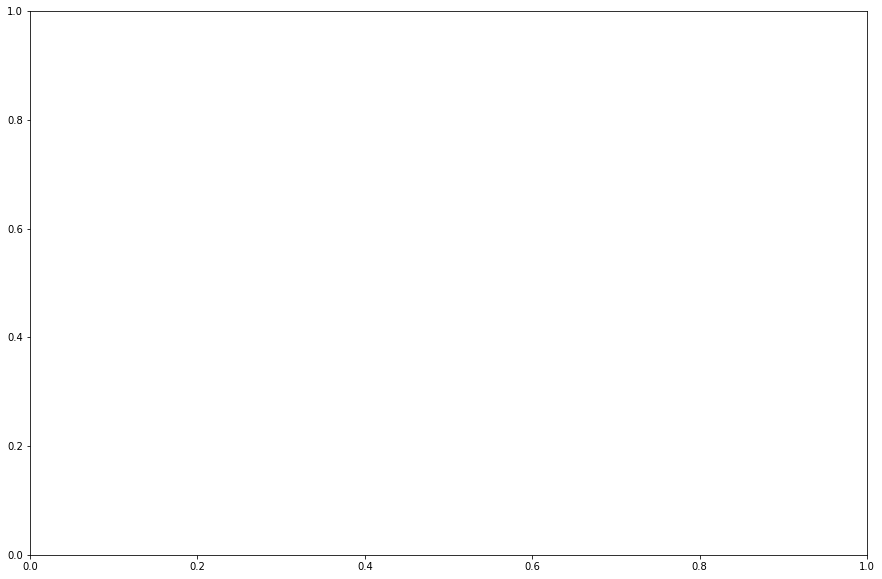

In [27]:
# Validation Accuracy 

class accuracy_plot(Test_Train):

  # a = Test_Train()
  
  def __init__(self):
    plt.figure(figsize=(15, 10))
    ax = plt.subplot(111)
    ax.plot(acc1)
    ax.plot(acc2)
    ax.plot(acc3)
    ax.plot(acc4)
    ax.set(title="Model Validation Accuracy of 4 Models with Batch-Normalization", xlabel="Epoch", ylabel="Accuracy")
    ax.legend(['without L1 and L2', 'with L1', 'with L2', 'with L1 and L2'], loc='best')
    plt.savefig("Accuracyof4modelswithBN.png")
    plt.show()


b = accuracy_plot()
b

In [0]:
# Validation Loss

class loss_plot(Test_Train):
  def __init__(self):
    plt.figure(figsize = (15,10))
    ax = plt.subplot(111)
    ax.plot(loss1)
    ax.plot(loss2)
    ax.plot(loss3)
    ax.plot(loss4)
    ax.set(title='Validation Losses of 4 Models with Batch-Normalization', xlabel='Epoch', ylabel = 'Loss')
    ax.legend(['without L1 & L2', 'with L1', 'with L2', 'with L1 & L2'], loc = 'best')
    plt.savefig('ValidationLossesBN.png')
    plt.show()

c = loss_plot()
c

In [0]:
# Misclassified Images

from google.colab import files
def misclassifiedOnes(model, filename):
  model = model.to(device)
  dataiter = iter(test_loader) 
  count = 0
  fig = plt.figure(figsize=(13,13))

  while count<25:
      images, labels = dataiter.next()
      images, labels = images.to(device), labels.to(device)
    
      output = model(images) 
      _, pred = torch.max(output, 1)   # convert output probabilities to predicted class
      images = images.cpu().numpy() # conv images to numpy format

      for idx in np.arange(128):
        if pred[idx]!=labels[idx]:
          ax = fig.add_subplot(5, 5, count+1, xticks=[], yticks=[])
          count=count+1
          ax.imshow(np.squeeze(images[idx]), cmap='cool')
          ax.set_title("Pred-{} (Target-{})".format(str(pred[idx].item()), str(labels[idx].item())), color="Black")
          if count==25:
            break
      plt.savefig(filename)
  files.download(filename)

   


In [0]:
print('Misclassifed Images from Model1')
print('*'*30)

model.load_state_dict(torch.load("model1.pt")) 
misclassifiedOnes(model,'withoutL1_L2_BN.png')
# save_image()

In [0]:
print('Misclassifed Images from Model2')
print('*'*30)

model.load_state_dict(torch.load("model2.pt")) 
misclassifiedOnes(model,'withL1_BN.png')

In [0]:
print('Misclassifed Images from Model3')
print('*'*30)
model.load_state_dict(torch.load("model3.pt")) 
misclassifiedOnes(model,'withL2_BN.png')

In [0]:
print('Misclassifed Images from Model4')
print('*'*30)

model.load_state_dict(torch.load("model4.pt")) 
misclassifiedOnes(model,'withL1_L2_BN.png')

In [0]:
# DataLoaders

class Dataloader:
  def __init__(self, shuffle = True, batch_size = 64):
      cuda = torch.cuda.is_available()
      if cuda:
        torch.cuda.manual_seed(seed)
      self.dataloader_args = dict(shuffle=shuffle, batch_size=batch_size, num_workers=4, pin_memory=True) #if cuda else dict(shuffle=True, batch_size=64)

  def dataset_loader(self, data):
      return torch.utils.data.DataLoader(data, **self.dataloader_args) # **dataloader_args get passed when dataset_loader gets called


dl = Dataloader()

# train dataloader
train_loader = dl.dataset_loader(train)

# test dataloader
test_loader = dl.dataset_loader(test)

In [0]:
# Main Model with Ghost Batch Normalization
# use diff batch size for GBN

class Net(nn.Module):
    def __init__(self):
      super(Net, self).__init__()

      # Conv Block1 
      self.convblock1 = nn.Sequential(
          nn.Conv2d(in_channels = 1, out_channels = 8, kernel_size = (3,3), padding = 0, bias = False), 
          nn.ReLU(),
          GhostBatchNorm(8,2)) # O/P: 26
      
      # Conv Block2
      self.convblock2 = nn.Sequential(
          nn.Conv2d(in_channels = 8, out_channels = 10, kernel_size = (3,3), padding = 0, bias = False),
          nn.ReLU(),
          GhostBatchNorm(10,2)) # O/P: 24

      # MaxPool Layer
      self.maxpool = nn.Sequential(nn.MaxPool2d((2,2))) # O/P: 12

      # ConvBlock 3
      self.convblock3 = nn.Sequential(
          nn.Conv2d(in_channels = 10, out_channels = 16, kernel_size = (3,3), padding = 0, bias = False),
          nn.ReLU(),
          GhostBatchNorm(16,2)) # O/P: 10
      
      
      # ConvBlock 4
      self.convblock4 = nn.Sequential(
          nn.Conv2d(in_channels = 16, out_channels = 16, kernel_size = (3,3), padding = 0, bias = False),
          nn.ReLU(),
          GhostBatchNorm(16,2)) # O/P: 8
      
      # ConvBlock 5
      self.convblock5 = nn.Sequential(
          nn.Conv2d(in_channels = 16, out_channels = 16, kernel_size = (3,3), padding = 0, bias = False),
          nn.ReLU(),
          GhostBatchNorm(16,2)) # O/P: 6

      # ConvBlock 6
      self.convblock6 = nn.Sequential(
          nn.Conv2d(in_channels = 16, out_channels = 16, kernel_size = (3,3), padding = 0,  bias = False))
         

    # GAP
      self.gap = nn.Sequential(nn.AvgPool2d(4))

    
    # Last Layer
      self.convblock9 = nn.Sequential(
          nn.Conv2d(in_channels = 16, out_channels = 10, kernel_size = (1,1), padding = 0, bias = False))


    # Dropout Layer
      self.drop = nn.Sequential(nn.Dropout(0.08))



    def forward(self,x):
      x = self.convblock1(x)
      x = self.drop(x)
      x = self.convblock2(x)
      x = self.drop(x)
      x = self.maxpool(x)
      x = self.convblock3(x)
      x = self.drop(x)
      x = self.convblock4(x)
      x = self.drop(x)
      x = self.convblock5(x)
      # x = self.drop(x)
      x = self.convblock6(x)
      x = self.gap(x)
      x = self.convblock9(x)
     
      x = x.view(-1, 10)
      return F.log_softmax(x, dim = -1)
      


# Ghost Batch Normalization

class BatchNorm(nn.BatchNorm2d):
    def __init__(self, num_features, eps=1e-05, momentum=0.1, weight=True, bias=True):
        super().__init__(num_features, eps=eps, momentum=momentum)
        self.weight.data.fill_(1.0) # fill_() helps you filling up the tensor with a particular data
        self.bias.data.fill_(0.0)
        self.weight.requires_grad = weight
        self.bias.requires_grad = bias


class GhostBatchNorm(BatchNorm):
    def __init__(self, num_features, num_splits, **kw):
        super().__init__(num_features, **kw)
        self.num_splits = num_splits
        self.register_buffer('running_mean', torch.zeros(num_features * self.num_splits))
        self.register_buffer('running_var', torch.ones(num_features * self.num_splits))
    def train(self, mode=True):
        if (self.training is True) and (mode is False):  # lazily collate stats when we are going to use them
            self.running_mean = torch.mean(self.running_mean.view(self.num_splits, self.num_features), dim=0).repeat(
                self.num_splits)
            self.running_var = torch.mean(self.running_var.view(self.num_splits, self.num_features), dim=0).repeat(
                self.num_splits)
        return super().train(mode)
    def forward(self, input):
        N, C, H, W = input.shape
        if self.training or not self.track_running_stats:
            return F.batch_norm(
                input.view(-1, C * self.num_splits, H, W), self.running_mean, self.running_var,
                self.weight.repeat(self.num_splits), self.bias.repeat(self.num_splits),
                True, self.momentum, self.eps).view(N, C, H, W)
        else:
            return F.batch_norm(
                input, self.running_mean[:self.num_features], self.running_var[:self.num_features],
                self.weight, self.bias, False, self.momentum, self.eps)




In [0]:
# GBN Model Summary 
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
modelGBN = Net().to(device)
summary(modelGBN, input_size=(1, 28, 28))

In [0]:
from tqdm import tqdm
import numpy as np

class Test_Train():
  def __init__(self):

# # This is to hold all the values and plot some graphs to extract few good insights.
    self.train_losses = []
    self.test_losses = []
    self.train_acc = []
    self.test_acc = []
    self.train_epoch_end = []
    self.test_loss_min = np.inf # setting it to infinity(max value)
    # when the test loss becomes min I will save the particular model


  def train(self, model, device, train_loader, optimizer, epoch,scheduler, L1lambda=None):
    model.train()    # prepare model for training
    pbar = tqdm(train_loader)
    correct = 0
    processed = 0
    for batch_idx, (data, target) in enumerate(pbar): # passing on data & target values to device
      data, target = data.to(device), target.to(device)
      optimizer.zero_grad()    # clear the gradients of all optimized variables
      
      # Predict
      y_pred = model(data)   # forward pass

      # Calculate loss
      loss = F.nll_loss(y_pred, target)

      #Implementing L1 Regularization
      if L1lambda:
        with torch.enable_grad():
          l1_loss = 0.
          for param in model.parameters():
            l1_loss += torch.sum(param.abs())
          loss += L1lambda * l1_loss

      self.train_losses.append(loss)

      # Backpropagation
      loss.backward()   # backward pass: compute gradient of the loss with respect to model parameters
      optimizer.step()   # perform a single optimization step (parameter update)

      # Update pbar-tqdm
    
      pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
      correct += pred.eq(target.view_as(pred)).sum().item()
      processed += len(data)

      pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
      self.train_acc.append(100*correct/processed)
      scheduler.step()
      self.train_epoch_end.append(self.train_acc[-1])


  def test(self, model, device, test_loader,filename):
      model.eval()  # prep model for evaluation
      test_loss = 0
      correct = 0
      with torch.no_grad():
          for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)  # forward pass: compute predicted outputs by passing inputs to the model
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

      test_loss /= len(test_loader.dataset)
      self.test_losses.append(test_loss)

      # save model if validation loss has decreased
      if test_loss <= self.test_loss_min:
          print('Validation loss has  decreased ({:.4f} --> {:.4f}).  Saving model ...'.format(self.test_loss_min, test_loss))
          torch.save(model.state_dict(), filename)
          self.test_loss_min = test_loss


      print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
          test_loss, correct, len(test_loader.dataset),
          100. * correct / len(test_loader.dataset)))
    
      self.test_acc.append(100. * correct / len(test_loader.dataset))

In [0]:
# Model 5

def withoutL1_L2_GBN():
  model =  Net().to(device)
  optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
  scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.1, steps_per_epoch=len(train_loader), epochs=25)

#first model
  print('without L1 and L2 regularization with GBN')
#without L1 and L2 regularization with GBN

  model5= Test_Train()
  global loss5
  global acc5
  loss5 = model5.test_losses
  acc5 = model5.test_acc

  EPOCHS = 25  
  for epoch in range(1,EPOCHS+1):
      print("EPOCH:", epoch)
      model5.train(model, device, train_loader, optimizer, epoch, scheduler)
      model5.test(model, device, test_loader,"model5.pt")



In [0]:
# Model 6

def withL1_GBN():
  model =  Net().to(device)
  optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
  scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.1, steps_per_epoch=len(train_loader), epochs=25)

#sixth model
  print('with L1 regularization with GBN')
#with L1 regularization with BN
  model6 = Test_Train()
  global loss6
  global acc6
  loss6 = model6.test_losses
  acc6 = model6.test_acc

  EPOCHS = 25
  for epoch in range(1,EPOCHS+1):
      print("EPOCH:", epoch)
      model6.train(model, device, train_loader, optimizer, epoch, scheduler, L1lambda = 1e-5)
      model6.test(model, device, test_loader,"model6.pt")

In [0]:

def withL2_GBN():
  model =  Net().to(device)
  optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9,weight_decay=1e-5)
  scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.1, steps_per_epoch=len(train_loader), epochs=25)

#seventh model
  print('with L2 regularization with GBN')
#with L2 regularization 
  model7 = Test_Train()
  global loss7
  global acc7
  loss7 = model7.test_losses
  acc7 = model7.test_acc

  EPOCHS = 25
  for epoch in range(1,EPOCHS+1):
      print("EPOCH:", epoch)
      model7.train(model, device, train_loader, optimizer, epoch, scheduler)
      model7.test(model, device, test_loader,"model7.pt")

In [0]:


def withL1_L2_GBN():
  model =  Net().to(device)
  optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9,weight_decay=1e-4)
  scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.1, steps_per_epoch=len(train_loader), epochs=25)

#eighth  model
  print('with L1 & L2 regularization with GBN')
#with both L1 & L2 regularization with BN
  model8 = Test_Train()
  global loss8
  global acc8
  loss8 = model8.test_losses
  acc8 = model8.test_acc

  EPOCHS = 25
  for epoch in range(1,EPOCHS+1):
      print("EPOCH:", epoch)
      model8.train(model, device, train_loader, optimizer, epoch, scheduler, L1lambda = 1e-5)
      model8.test(model, device, test_loader,"model8.pt")

In [0]:
# Validation Accuracy 

class accuracy_plot(Test_Train):

  # a = Test_Train()
  
  def __init__(self):
    plt.figure(figsize=(15, 10))
    ax = plt.subplot(111)
    ax.plot(acc5)
    ax.plot(acc6)
    ax.plot(acc7)
    ax.plot(acc8)
    ax.set(title="Model Validation Accuracy of 4 Models with Ghost-Batch Normalization", xlabel="Epoch", ylabel="Accuracy")
    ax.legend(['without L1 and L2', 'with L1', 'with L2', 'with L1 and L2'], loc='best')
    plt.savefig("Accuracyof4modelswithGBN.png")
    plt.show()

d = accuracy_plot()
d



In [0]:
# Validation Loss

class loss_plot(Test_Train):
  def __init__(self):
    plt.figure(figsize = (15,10))
    ax = plt.subplot(111)
    ax.plot(loss5)
    ax.plot(loss6)
    ax.plot(loss7)
    ax.plot(loss8)





    ax.plot(Test_Train.test_losses)
    ax.plot(Test_Train.test_losses)
    ax.plot(Test_Train.test_losses)
    ax.set(title='Validation Losses of 4 Models with Ghost-Batch-Normalization', xlabel='Epoch', ylabel = 'Loss')
    ax.legend(['without L1 & L2', 'with L1', 'with L2', 'with L1 & L2'], loc = 'best')
    plt.savefig('ValidationLossesGBN.png')
    plt.show()

e = loss_plot()
e


In [0]:
GBNmodelTuple = iter(withoutL1_L2_GBN(),
  withL1_GBN(),
  withL2_GBN(),
  withL1_L2_GBN())

print(GBNmodelTuple.__next__())

In [0]:
print('Misclassifed Images from Model4')
print('*'*30)

model.load_state_dict(torch.load("model4.pt")) 
misclassifiedOnes(model,'withoutL1_L2_GBN.png')

In [0]:
print('Misclassifed Images from Model5')
print('*'*30)

model.load_state_dict(torch.load("model5.pt")) 
misclassifiedOnes(model,'withL1_GBN.png')

In [0]:
print('Misclassifed Images from Model7')
print('*'*30)

model.load_state_dict(torch.load("model7.pt")) 
misclassifiedOnes(model,'withL2_GBN.png')

In [0]:
print('Misclassifed Images from Model8')
print('*'*30)

model.load_state_dict(torch.load("model8.pt")) 
misclassifiedOnes(model,'withL1_L2_GBN.png')